In [1]:
import os
from tvb.simulator.lab import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
LOG = get_logger('demo')
import pickle as cPickle
from tvb.simulator.models.stefanescu_jirsa import ReducedSetHindmarshRose
from os.path import join as pjoin
from sklearn import preprocessing
import scipy.signal as signal
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]

/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
basedir = "/Volumes/lab4data/K21_raw/"
only_go = pjoin(basedir, "local_inhibition_only_go")
only_gc = pjoin(basedir, "local_inhibition_only_gc")
go_gc_K21 = pjoin(basedir, "local_inhibition_lfp_K21")

In [3]:
# generate a sos bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs # nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    sos = signal.butter(order, [low, high], analog=False, btype="band", output="sos")
    return sos

def detect_frequency(file, type, group, caseid):
    lfp_data = np.load(file) # a npy file
    # detect spikes using scipy.signal.find_peaks
    peaks_l, _ = signal.find_peaks(lfp_data[8192:, 0, 4, 0], prominence=1)
    # calculate frequency
    freq_l_gamma = len(peaks_l) / 10
    peaks_r, _ = signal.find_peaks(lfp_data[8192:, 0, 5, 0], prominence=1)
    freq_r_gamma = len(peaks_r) / 10

    # conduct signal downsample first
    lfp_data_down_l = signal.decimate(lfp_data[8192:,0,4,0], 100, axis=0, zero_phase=True)
    lfp_data_down_r = signal.decimate(lfp_data[8192:,0,5,0], 100, axis=0, zero_phase=True)
    # then bandpass filter
    sos = butter_bandpass(2, 10, 81920/100)
    lfp_data_filtered_l = signal.sosfiltfilt(sos, lfp_data_down_l)
    lfp_data_filtered_r = signal.sosfiltfilt(sos, lfp_data_down_r)

    # detect spikes using scipy.signal.find_peaks
    peaks_filtered_l, _ = signal.find_peaks(lfp_data_filtered_l, prominence=0.2)
    peaks_filtered_r, _ = signal.find_peaks(lfp_data_filtered_r, prominence=0.2)

    # calculate frequency
    freq_l_theta = len(peaks_filtered_l) / 10
    freq_r_theta = len(peaks_filtered_r) / 10
    figure = plt.figure(figsize=(10, 5))
    ax1 = figure.add_subplot(2, 1, 1)
    ax1.plot(lfp_data[8192:, 0, 4, 0], label="left")
    ax1.plot(lfp_data[8192:, 0, 5, 0], label="right")
    ax1.plot(peaks_l, lfp_data[peaks_l+8192, 0, 4, 0], "x")
    ax1.plot(peaks_r, lfp_data[peaks_r+8192, 0, 5, 0], "x")
    ax1.legend()
    ax2 = figure.add_subplot(2, 1, 2)
    ax2.plot(lfp_data_filtered_l, label="left_filtered")
    ax2.plot(lfp_data_filtered_r, label="right_filtered")
    ax2.plot(peaks_filtered_l, lfp_data_filtered_l[peaks_filtered_l], "x")
    ax2.plot(peaks_filtered_r, lfp_data_filtered_r[peaks_filtered_r], "x")
    ax2.legend()
    plt.title(f"{type}_{group}_{caseid}")
    plt.savefig(f"/Users/yilewang/Desktop/{type}/{group}_{caseid}.png")
    plt.close()
    return freq_l_gamma, freq_r_gamma, freq_l_theta, freq_r_theta

def lateralization_index(freq_l, freq_r):
    if freq_l + freq_r == 0:
        return 0
    else:
        return np.abs(freq_l - freq_r) / (freq_l + freq_r)

In [4]:
# read mega data
mega_data = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')
# read k21.txt save as variable k21
K21 = np.loadtxt(f'/Users/yilewang/workspaces/tvbdemos/clinical_conversion/local_inhibition_lfp/K21.txt', dtype=float)

In [171]:

# create a dataframe for all subjects
local_inhibition = pd.DataFrame(columns=['group', 'caseid',
                                        'gamma_frequency_left_go', 'gamma_frequency_right_go', 
                                        'theta_frequency_left_go', 'theta_frequency_right_go',
                                        'gamma_frequency_left_go_K21', 'gamma_frequency_right_go_K21', 'theta_frequency_left_go_K21', 'theta_frequency_right_go_K21',
                                        'gamma_frequency_left_gc', 'gamma_frequency_right_gc', 'theta_frequency_left_gc', 'theta_frequency_right_gc',
                                        'gamma_frequency_left_gc_K21', 'gamma_frequency_right_gc_K21', 'theta_frequency_left_gc_K21', 'theta_frequency_right_gc_K21',
                                        'gamma_frequency_go_lateralization', 'theta_frequency_go_lateralization', 'gamma_frequency_go_K21_lateralization', 'theta_frequency_go_K21_lateralization',
                                        'gamma_frequency_gc_lateralization', 'theta_frequency_gc_lateralization', 'gamma_frequency_gc_K21_lateralization', 'theta_frequency_gc_K21_lateralization'])
for case, gr, gc, go, k21 in zip(mega_data.caseid, mega_data.group, mega_data.Gc, mega_data.Go, K21):
    # read from local_inhibition_only_go
    file_go = pjoin(only_go, gr, f'{case}_{go}.npy')
    freq_l_gamma_go, freq_r_gamma_go, freq_l_theta_go, freq_r_theta_go = detect_frequency(file_go, 'only_go', gr, case)
    freq_gamma_go_la =  lateralization_index(freq_l_gamma_go, freq_r_gamma_go)
    freq_theta_go_la = lateralization_index(freq_l_theta_go, freq_r_theta_go)
    # read from local_inhibition_go_K21
    file_go_K21 = pjoin(go_gc_K21, gr, f'{case}_{go}.npy')
    freq_l_gamma_go_K21, freq_r_gamma_go_K21, freq_l_theta_go_K21, freq_r_theta_go_K21 = detect_frequency(file_go_K21, 'go_K21', gr, case)
    freq_gamma_go_K21_la =  lateralization_index(freq_l_gamma_go_K21, freq_r_gamma_go_K21)
    freq_theta_go_K21_la = lateralization_index(freq_l_theta_go_K21, freq_r_theta_go_K21)
    # read from local_inhibition_only_gc
    file_gc = pjoin(only_gc, gr, f'{case}_{gc}.npy')
    freq_l_gamma_gc, freq_r_gamma_gc, freq_l_theta_gc, freq_r_theta_gc = detect_frequency(file_gc, 'only_gc', gr, case)
    freq_gamma_gc_la =  lateralization_index(freq_l_gamma_gc, freq_r_gamma_gc)
    freq_theta_gc_la = lateralization_index(freq_l_theta_gc, freq_r_theta_gc)
    # read from local_inhibition_gc_K21
    file_gc_K21 = pjoin(go_gc_K21, gr, f'{case}_{gc}.npy')
    freq_l_gamma_gc_K21, freq_r_gamma_gc_K21, freq_l_theta_gc_K21, freq_r_theta_gc_K21 = detect_frequency(file_gc_K21, 'gc_K21', gr, case)
    freq_gamma_gc_K21_la =  lateralization_index(freq_l_gamma_gc_K21, freq_r_gamma_gc_K21)
    freq_theta_gc_K21_la = lateralization_index(freq_l_theta_gc_K21, freq_r_theta_gc_K21)

    # concate all variables to a dataframe
    local_inhibition = pd.concat([local_inhibition, pd.DataFrame({'group':gr, 'caseid':case, 
                                        'gamma_frequency_left_go': freq_l_gamma_go, 'gamma_frequency_right_go':freq_r_gamma_go, 
                                        'theta_frequency_left_go':freq_l_theta_go, 'theta_frequency_right_go':freq_r_theta_go,
                                        'gamma_frequency_left_go_K21':freq_l_gamma_go_K21, 'gamma_frequency_right_go_K21':freq_r_gamma_go_K21, 'theta_frequency_left_go_K21':freq_l_theta_go_K21, 'theta_frequency_right_go_K21':freq_r_theta_go_K21,
                                        'gamma_frequency_left_gc':freq_l_gamma_gc, 'gamma_frequency_right_gc':freq_r_gamma_gc, 'theta_frequency_left_gc':freq_l_theta_gc, 'theta_frequency_right_gc':freq_r_theta_gc,
                                        'gamma_frequency_left_gc_K21':freq_l_gamma_gc_K21, 'gamma_frequency_right_gc_K21':freq_r_gamma_gc_K21, 'theta_frequency_left_gc_K21':freq_l_theta_gc_K21, 'theta_frequency_right_gc_K21':freq_r_theta_gc_K21,
                                        'gamma_frequency_go_lateralization':freq_gamma_go_la, 'theta_frequency_go_lateralization':freq_theta_go_la, 'gamma_frequency_go_K21_lateralization':freq_gamma_go_K21_la, 'theta_frequency_go_K21_lateralization':freq_theta_go_K21_la,
                                        'gamma_frequency_gc_lateralization':freq_gamma_gc_la, 'theta_frequency_gc_lateralization':freq_theta_gc_la, 'gamma_frequency_gc_K21_lateralization':freq_gamma_gc_K21_la, 'theta_frequency_gc_K21_lateralization':freq_theta_gc_K21_la}, index=[0])], axis=0)

    print(local_inhibition)



  group caseid  gamma_frequency_left_go  gamma_frequency_right_go  \
0   SNC  2820A                      2.8                      28.2   

   theta_frequency_left_go  theta_frequency_right_go  \
0                      4.9                       6.4   

   gamma_frequency_left_go_K21  gamma_frequency_right_go_K21  \
0                          2.0                          26.8   

   theta_frequency_left_go_K21  theta_frequency_right_go_K21  ...  \
0                          4.7                           6.7  ...   

   theta_frequency_left_gc_K21  theta_frequency_right_gc_K21  \
0                          5.1                           6.8   

   gamma_frequency_go_lateralization  theta_frequency_go_lateralization  \
0                           0.819355                           0.132743   

   gamma_frequency_go_K21_lateralization  \
0                               0.861111   

   theta_frequency_go_K21_lateralization  gamma_frequency_gc_lateralization  \
0                               

In [172]:
local_inhibition.to_excel("/Users/yilewang/Desktop/local_inhibition_all.xlsx")

In [84]:
import sys
sys.path.append('/Users/yilewang/workspaces/')
from tvbtools.tools import statools

sign_table = statools.stats_calculator(local_inhibition, tails="greater")
# sign_table.to_csv('/Users/yilewang/Desktop/local_inhibition_lfp4types_sign_table.csv')

In [109]:
print(sign_table)

                 (SNC, NC)  (SNC, MCI)  (SNC, AD)  (NC, MCI)  \
gamma_l_go        0.567243    0.127787   0.127787   0.092391   
gamma_r_go        0.611139    0.442876   0.076592   0.328617   
theta_l_go        0.635136    0.167683   0.138186   0.092091   
theta_r_go        0.804520    0.743566   0.275972   0.300270   
gamma_l_go_K21    0.645535    0.165433   0.064993   0.064993   
gamma_r_go_K21    0.593441    0.460514   0.062794   0.401060   
theta_l_go_K21    0.648835    0.190481   0.139386   0.110989   
theta_r_go_K21    0.778822    0.687171   0.258974   0.321868   
gamma_l_gc        0.786821    0.568863   0.174733   0.174733   
gamma_r_gc        0.900810    0.552905   0.273723   0.118788   
theta_l_gc        0.758224    0.384442   0.199580   0.199580   
theta_r_gc        0.962404    0.529147   0.529147   0.061794   
gamma_l_gc_K21    0.810219    0.675532   0.223178   0.223178   
gamma_r_gc_K21    0.907309    0.534787   0.253025   0.149385   
theta_l_gc_K21    0.707029    0.398000  

In [113]:
local_inhibition = pd.read_csv('/Users/yilewang/Desktop/local_inhibition_all.csv')

gamma_l_gc
gamma_l_gc_K21


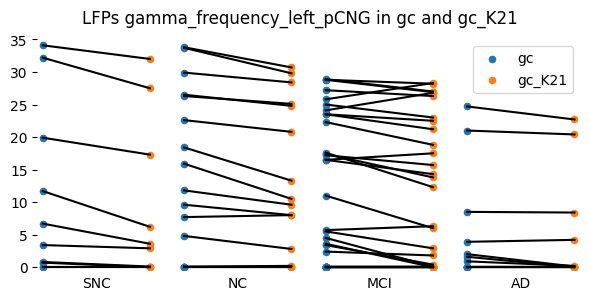

gamma_r_gc
gamma_r_gc_K21


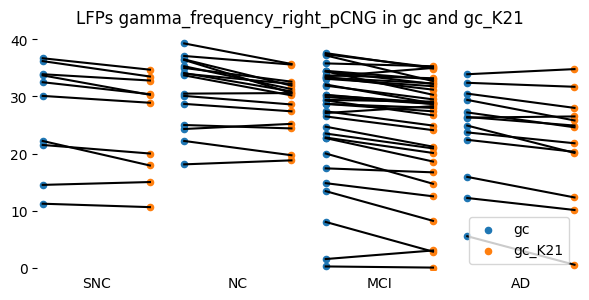

theta_l_gc
theta_l_gc_K21


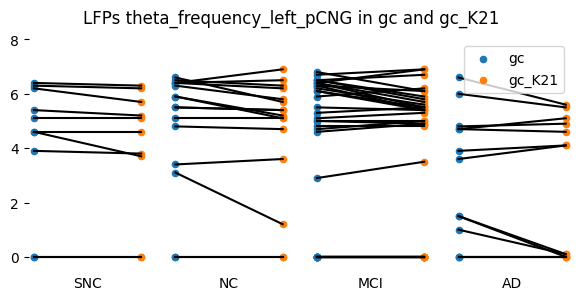

theta_r_gc
theta_r_gc_K21


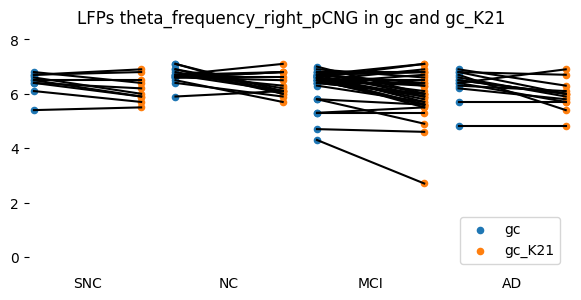

In [162]:
types = 'gc'

titles = ["gamma_frequency_left_pCNG", "gamma_frequency_right_pCNG", "theta_frequency_left_pCNG", "theta_frequency_right_pCNG"]
# titles = ["gamma_lateralization", "theta_lateralization"]

def before_after_graph(befores, afters, ax=ax1, ylim=[-0.5, 35]):
    # plotting the points
    ax.scatter(np.zeros(len(befores)), befores, s=20)
    ax.scatter(np.ones(len(afters)), afters, s=20)
    # plotting the lines
    for i in range(len(befores)):
        ax.plot( [0,1], [befores[i], afters[i]], c='k')
    # hide the frame
    ax.set_frame_on(False)
    # ax.set_xticks([0.25, 0.75], ['gc', 'gc_K21'])
    ax.set_xticks([])
    # find max of befores and afters
    ax.set_ylim(ylim)



groups = ["SNC", "NC", "MCI", "AD"]
ylims = [[-0.5, 35], [-0.5, 40], [-0.5, 8], [-0.5, 8]]


for index, i in enumerate(range(8,12)):
    print(local_inhibition.columns[i+2])
    print(local_inhibition.columns[i+6]) 
    figure = plt.figure(figsize=(7, 3))
    # set title
    figure.suptitle(f"LFPs {titles[index]} in {types} and {types}_K21")
    ax1 = figure.add_subplot(1, 4, 1)
    ax2 = figure.add_subplot(1, 4, 2)
    ax2.set_yticklabels([])
    ax2.set_yticks([])
    ax3 = figure.add_subplot(1, 4, 3)
    ax3.set_yticklabels([])
    ax3.set_yticks([])
    ax4 = figure.add_subplot(1, 4, 4)
    ax4.set_yticklabels([])
    ax4.set_yticks([])
    axs = [ax1, ax2, ax3, ax4]
    for gg, ax, ylim in zip(groups, axs, ylims):
        # take only one group data
        group_data_before = np.array(local_inhibition[local_inhibition.group == gg][local_inhibition.columns[i+2]])
        group_data_after = np.array(local_inhibition[local_inhibition.group == gg][local_inhibition.columns[i+6]])
        before_after_graph(group_data_before, group_data_after, ax=ax, ylim=ylims[index])
        ax.set_xlabel(gg)
    plt.legend([types, f'{types}_K21'])
    plt.show()







### K21_conditions

gamma_frequency_left_go
gamma_frequency_right_go
theta_frequency_left_go
theta_frequency_right_go


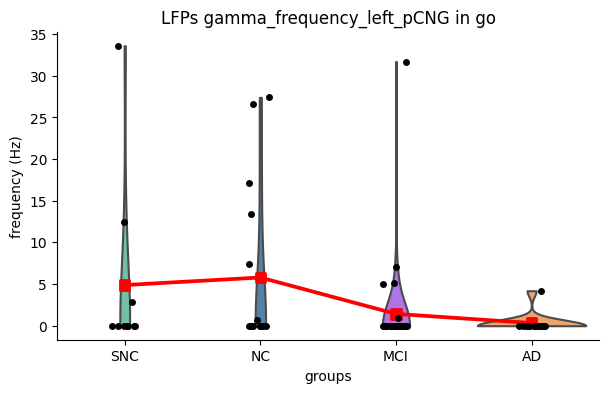

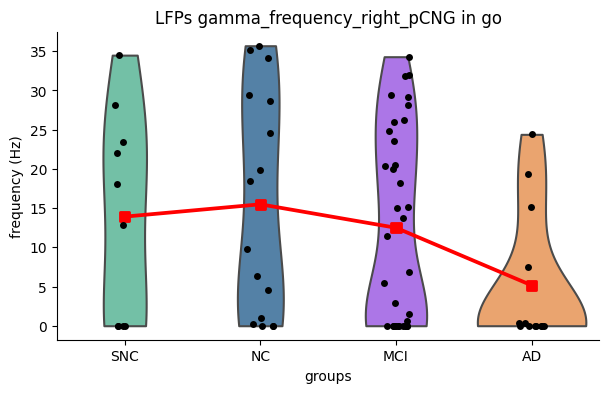

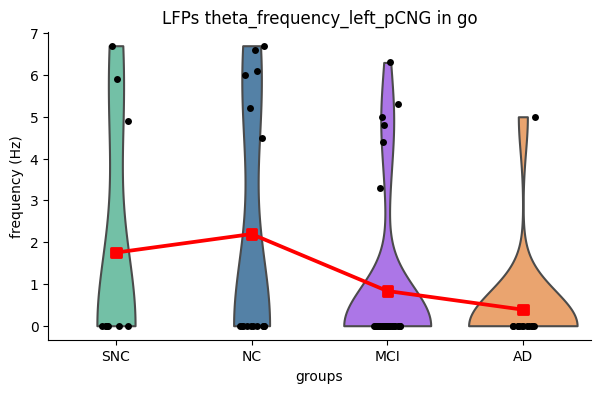

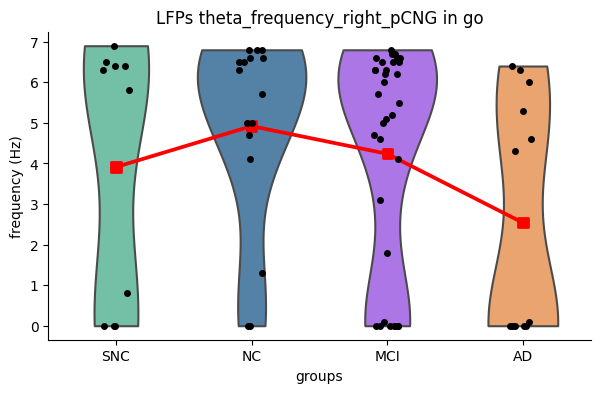

In [60]:
types = "go"
g_table = pd.read_excel('/Users/yilewang/Desktop/K21_table.xlsx', sheet_name=types)
titles = ["gamma_frequency_left_pCNG", "gamma_frequency_right_pCNG", "theta_frequency_left_pCNG", "theta_frequency_right_pCNG"]

for index, i in enumerate(range(2,6)):
    figure = plt.figure(figsize=(7, 4))
    print(g_table.columns[i])
    sns.violinplot(x="group", y=g_table.columns[i], data=local_inhibition, palette=colors, inner=None, cut=0)
    sns.pointplot(x="group", y=g_table.columns[i], data=local_inhibition, color="red", join=True, errorbar=None, markers = 's')
    # sns plot points with dodge
    sns.stripplot(x="group", y=g_table.columns[i], data=local_inhibition, dodge=True, jitter=True, color="black")
    # replace y label to frequency
    plt.ylabel("frequency (Hz)")
    plt.xlabel("groups")
    # hide top and right frame
    sns.despine()
    # set title
    plt.title(f"LFPs {titles[index]} in {types}")

### K21_G comparison

gamma_frequency_left_go
gamma_frequency_right_go
theta_frequency_left_go
theta_frequency_right_go


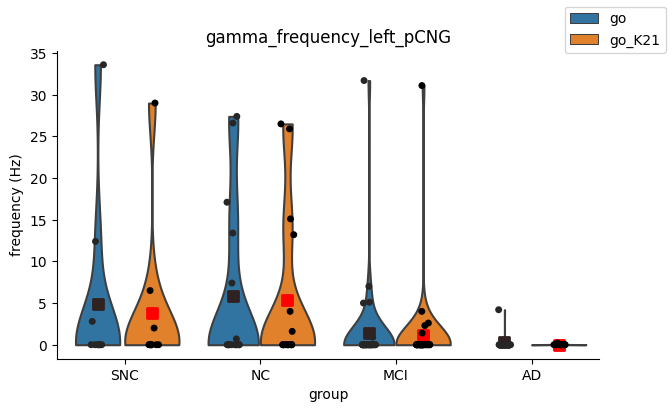

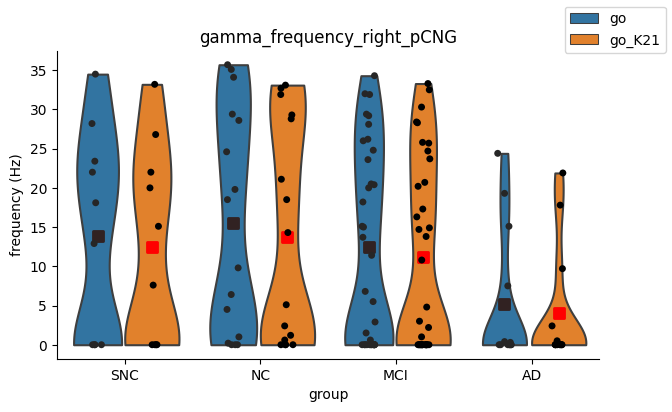

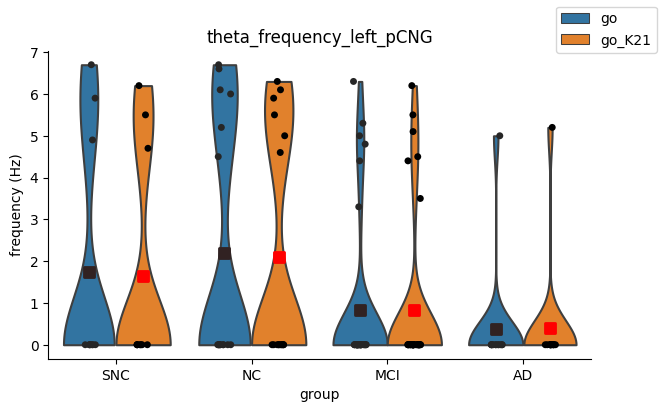

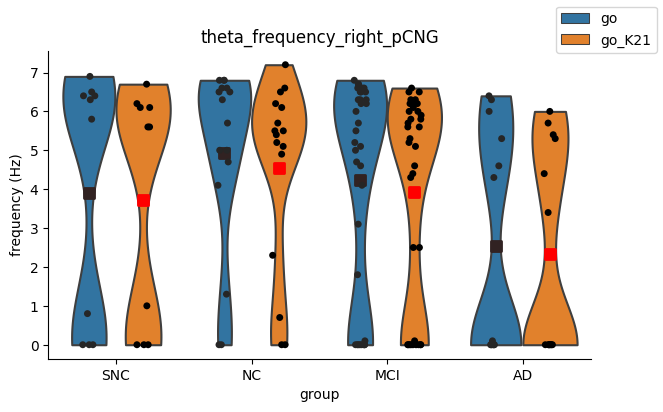

In [61]:
titles = ["gamma_frequency_left_pCNG", "gamma_frequency_right_pCNG", "theta_frequency_left_pCNG", "theta_frequency_right_pCNG"]
hemi = [types] * 74 + [f'{types}_K21'] * 74
# set title
for index, i in enumerate(range(4)):
    figure = plt.figure(figsize=(7, 4))
    print(g_table.columns[i+2])
    # plot violinplot
    y_data = pd.concat([g_table.iloc[:,i+2], g_table.iloc[:,i+6]], axis=0)
    group_concat = pd.concat([g_table.group, g_table.group], axis=0)
    sns.violinplot(x=group_concat, y=y_data, hue = hemi, cut=0, bw=.4, inner=None)
    sns.pointplot(x=group_concat, y=y_data, hue=hemi, dodge=0.4, markers="s", color="red", errorbar=None, linestyles="", label=None)
    sns.stripplot(x=group_concat, y=y_data, hue=hemi, dodge=True, jitter=True,palette='dark:black', label=None)
    plt.ylabel("frequency (Hz)")
    plt.title(titles[index])
    sns.despine()
    plt.legend([],[], frameon=False)
    # only keep violinplot legend
    handles, labels = figure.gca().get_legend_handles_labels()
    figure.legend(handles[:2], labels[:2], loc='upper right')


gamma_frequency_left_go
gamma_frequency_left_go_K21
gamma_frequency_right_go
gamma_frequency_right_go_K21
theta_frequency_left_go
theta_frequency_left_go_K21
theta_frequency_right_go
theta_frequency_right_go_K21


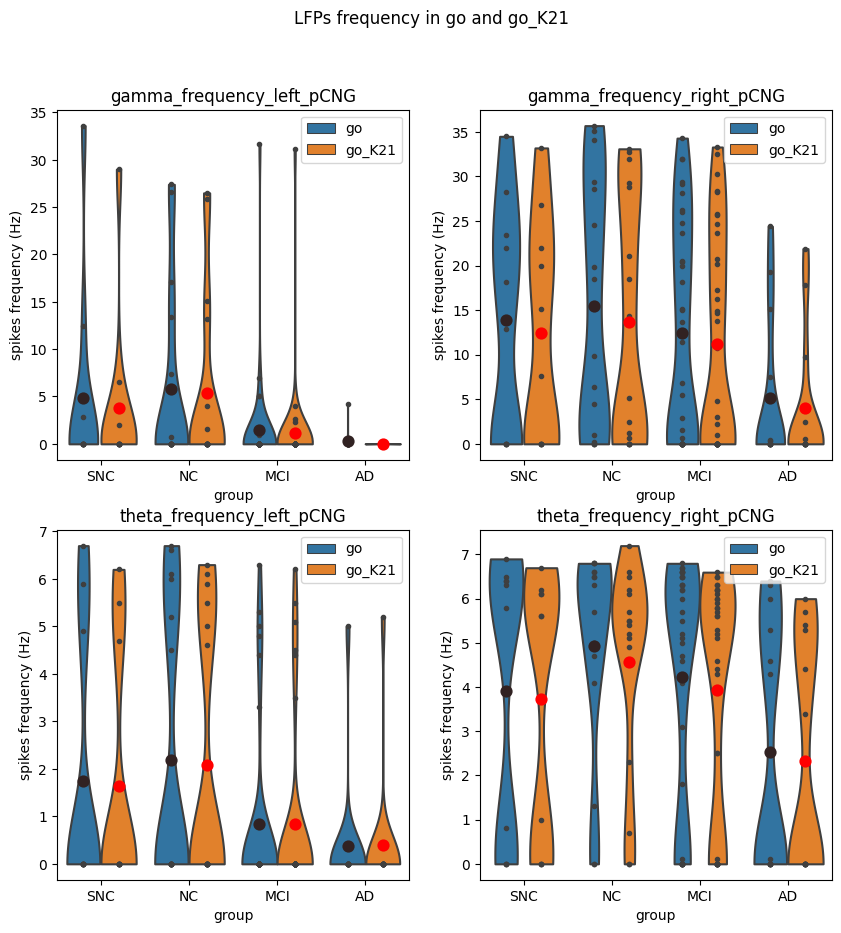

In [194]:
types = 'go'
parameters = [f'{types}'] * 74 + [f'{types}_K21'] * 74
titles = ["gamma_frequency_left_pCNG", "gamma_frequency_right_pCNG", "theta_frequency_left_pCNG", "theta_frequency_right_pCNG"]
figure = plt.figure(figsize=(10, 10))
# set title
figure.suptitle(f"LFPs frequency in {types} and {types}_K21")
for index, i in enumerate(range(4)):
    print(local_inhibition.columns[i+2])
    print(local_inhibition.columns[i+6])
    # concate local_inhibition.gamma_l_go and local_inhibition.gamma_l_go_K21
    y_data = pd.concat([local_inhibition.iloc[:,i+2], local_inhibition.iloc[:,i+6]], axis=0)
    group_concat = pd.concat([local_inhibition.group, local_inhibition.group], axis=0)

    # plot violinplot
    ax1 = figure.add_subplot(2, 2, index+1)

    sns.violinplot(x=group_concat, y=y_data, hue=parameters, cut=0, bw=.4, ax=ax1, inner="point")
    sns.pointplot(x=group_concat, y=y_data, hue=parameters, ax=ax1, dodge=.4, markers="o", color="red", errorbar=None, linestyles="none",label=None)
    ax1.set_ylabel("spikes frequency (Hz)")
    # sns.stripplot(x=group_concat, y=y_data, hue=parameters, dodge = True, ax=ax1)
    ax1.set_title(titles[index])
    # remove legend of pointplot
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[:2], labels[:2])
plt.show()


gamma_gc_la
gamma_gc_K21_la
theta_gc_la
theta_gc_K21_la


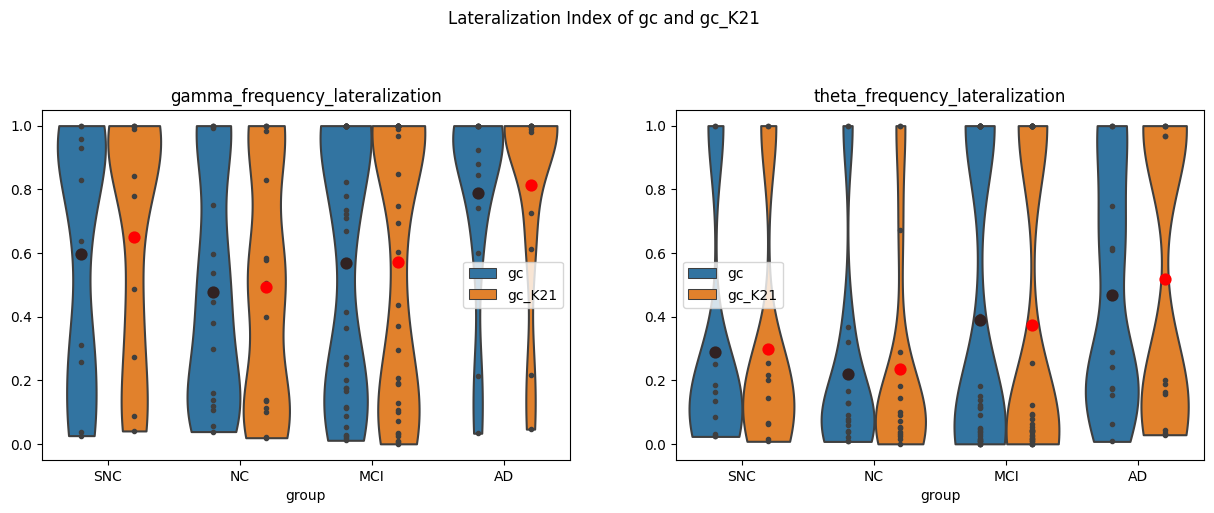

In [163]:
types = 'gc'
# generate a list with first 74 items as "go", and the last 74 items as "go_K21"
parameters = [f'{types}'] * 74 + [f'{types}_K21'] * 74

# titles = ["gamma_left", "gamma_right", "theta_left", "theta_right"]
titles = ["gamma_frequency_lateralization", "theta_frequency_lateralization"]
figure = plt.figure(figsize=(15, 10))
figure.suptitle(f"Lateralization Index of {types} and {types}_K21")
for index, i in enumerate(range(20,22)):
    print(local_inhibition.columns[i+2])
    print(local_inhibition.columns[i+4])
    # concate local_inhibition.gamma_l_go and local_inhibition.gamma_l_go_K21
    y_data = pd.concat([local_inhibition.iloc[:,i+2], local_inhibition.iloc[:,i+4]], axis=0)
    group_concat = pd.concat([local_inhibition.group, local_inhibition.group], axis=0)

    # plot violinplot
    ax1 = figure.add_subplot(2, 2, index+1)
    sns.violinplot(x=group_concat, y=y_data, hue=parameters, cut=0, bw=.4, ax=ax1, inner="point")
    # sns.stripplot(x=group_concat, y=y_data, hue=parameters, dodge = True, ax=ax1)
    # plot mean point using red dot with error bar
    sns.pointplot(x=group_concat, y=y_data, hue=parameters, ax=ax1, dodge=.4, markers="o", color="red", errorbar=None, linestyles="none")
    ax1.set_title(titles[index])
    # remove legend of pointplot
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[:2], labels[:2])
plt.show()

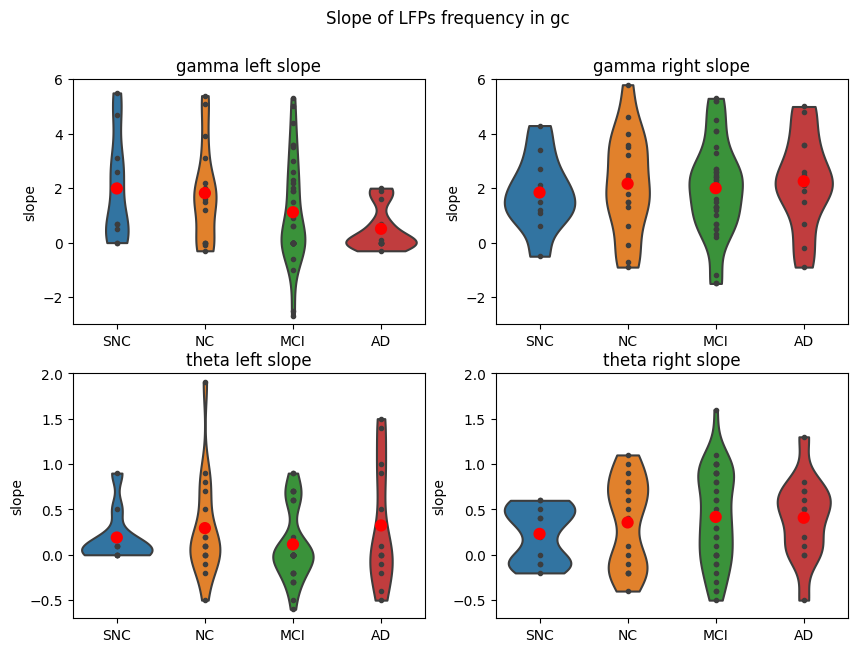

In [51]:
hemi = ["left", "right"]
band = ["gamma", "theta"]
total = pd.read_excel("/Users/yilewang/Desktop/K21_table.xlsx", sheet_name="gc")
figure = plt.figure(figsize=(10, 7))
figure.suptitle("Slope of LFPs frequency in gc")
ind = 0
for i in band:
    for j in hemi:
        ax1 = figure.add_subplot(2, 2, ind+1)
        sns.violinplot(x="group", y=f"{i}_{j}_differences", cut=0, bw=.4, inner="point", data=total)
        sns.pointplot(x="group", y=f"{i}_{j}_differences", data=total, markers="o", color="red", errorbar=None, linestyles="none")
        ax1.set_title(f"{i} {j} slope")
        ax1.set_ylabel("slope")
        ax1.set_xlabel("")
        if i == "theta":
            ax1.set_ylim([-0.7, 2])
        else:
            ax1.set_ylim([-3, 6])
        ind+=1

In [ ]:
# for case, gr, gc, go, k21 in zip(mega_data.caseid, mega_data.group, mega_data.Gc, mega_data.Go, K21):
#     # read from local_inhibition_only_go
#     file_go = pjoin(only_go, gr, f'{case}_{go}.npy')
#     freq_l_go, freq_r_go = detect_frequency(file_go, gr, case, 'only_go')
#     # read from local_inhibition_only_gc
#     file_gc = pjoin(only_gc, gr, f'{case}_{gc}.npy')
#     freq_l_gc, freq_r_gc = detect_frequency(file_gc, gr, case, 'only_gc')

#     # read from local_inhibition_go_K21
#     file_go_K21 = pjoin(go_K21, gr, f'{case}_go_{go}.npy')
#     freq_l_go_K21, freq_r_go_K21 = detect_frequency(file_go_K21, gr, case, 'go_K21')

#     # read from local_inhibition_gc_K21
#     file_gc_K21 = pjoin(gc_K21, gr, f'{case}_{k21}.npy')
#     freq_l_gc_K21, freq_r_gc_K21 = detect_frequency(file_gc_K21, gr, case, 'gc_K21')


In [ ]:
local_inhibition = pd.read_excel('/Users/yilewang/Desktop/local_inhibition.xlsx', sheet_name='go')
figure = plt.figure(figsize=(10, 5))
# plot two violin plots
sns.violinplot(x="group", y="freq_l_go", hue="local", data=local_inhibition,cut=0, bw=.4)
plt.show()
sns.violinplot(x="group", y="freq_r_go", hue="local", data=local_inhibition,cut=0, bw=.4)
plt.show()
sns.violinplot(x="group", y="la_go", hue="local", data=local_inhibition,cut=0, bw=.4)

In [ ]:
# sys.path.append('/Users/yilewang/workspaces/tvbtools')

The P-value of the Permutation Test is: 0.39976002399760024


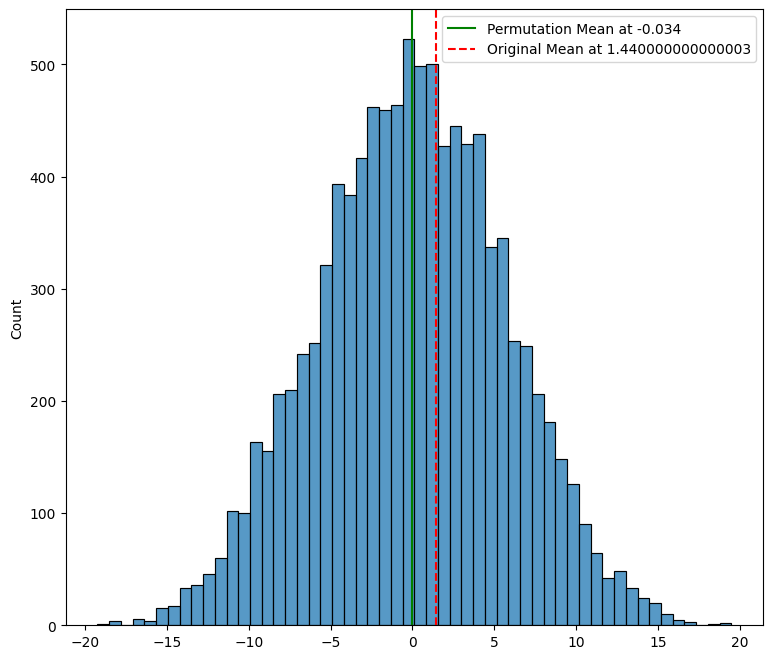

The P-value of the Permutation Test is: 0.36666333366663334


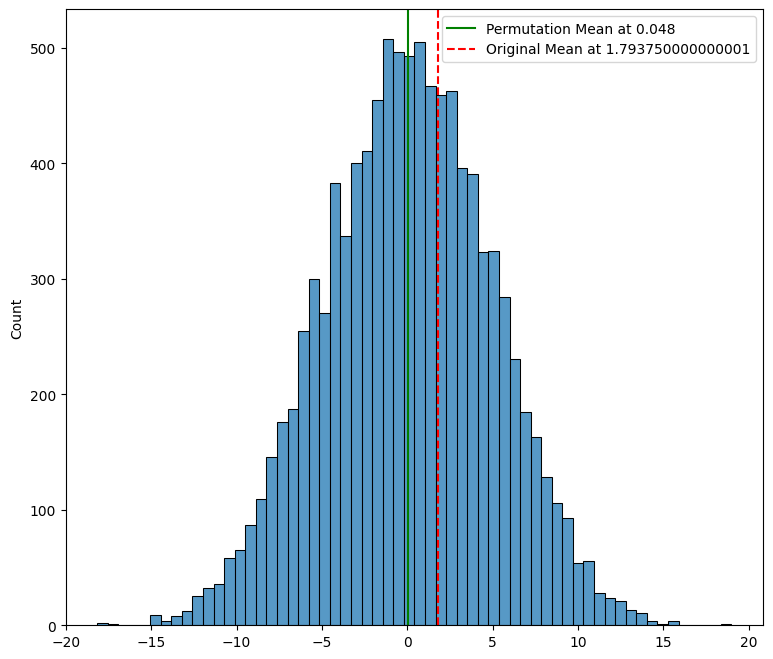

The P-value of the Permutation Test is: 0.3294670532946705


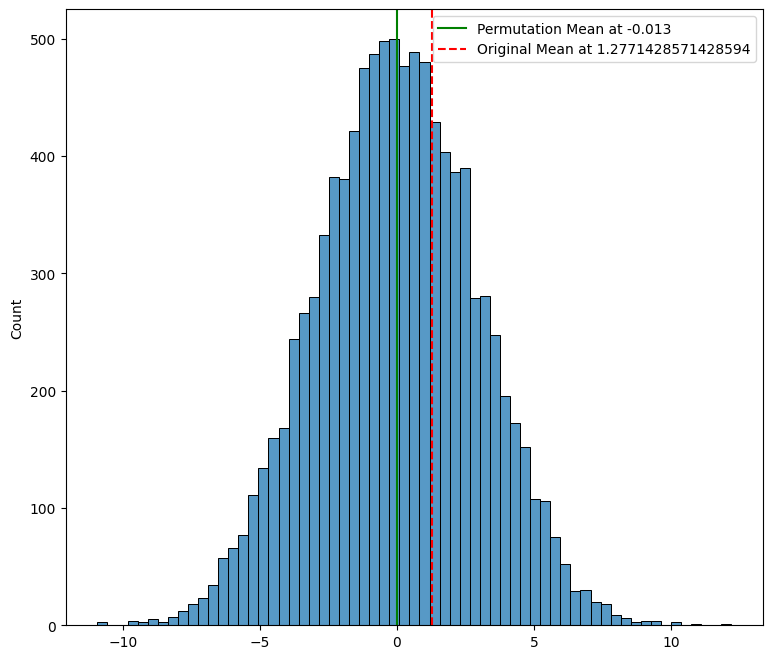

The P-value of the Permutation Test is: 0.3701629837016298


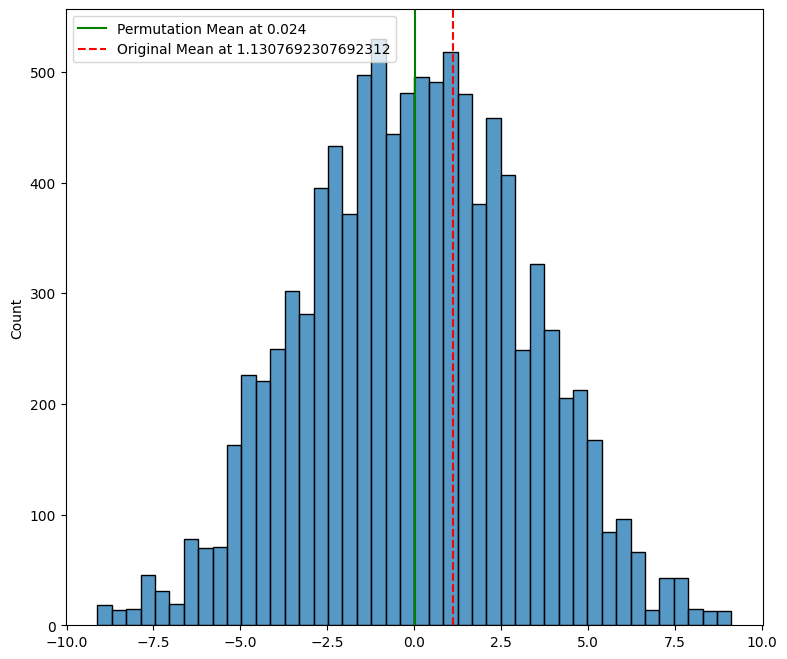

In [177]:
# permutation test, import tvbtools from /Users/yilewang/workspaces/tvbtools
import sys
from tvbtools.tools.statools import permutation_test
groups = ['SNC', 'NC', 'MCI', 'AD']
for i in groups:
    permutation_test(local_inhibition[local_inhibition.group == i].gamma_frequency_right_go, local_inhibition[local_inhibition.group == i].gamma_frequency_right_go_K21, 10000,True)


